# Projet : Détection de fraude bancaire

**Auteur :** Mohamed Lamine OULD BOUYA  
**Objectif :** Concevoir un modèle de classification capable d’identifier les transactions frauduleuses avec un haut rappel et une bonne précision-rappel (PR-AUC), malgré un déséquilibre extrême entre transactions normales et frauduleuses.

📊 Données
- Source : [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)  
- Taille : 284 807 transactions, dont seulement 0.17 % de fraudes

⚙️ Stack technique
- Langage : Python
- Librairies : pandas, scikit-learn, imbalanced-learn, XGBoost, RandomForest

🧩 Méthodologie
- Prétraitement : standardisation + gestion du déséquilibre via SMOTE
- Validation : split stratifié (80/20) et cross-validation stratifiée (CV) pour le tuning d’hyperparamètres
- Optimisation : GridSearchCV sur Logistic Regression (pénalité et régularisation)

📈 Évaluation
- Métriques principales :
-- PR-AUC (Average Precision)
-- ROC-AUC
-- Rappel (Recall), Précision, F1-score
-- Matrice de confusion
- Comparaison de modèles :
Logistic Regression (baseline et optimisée), RandomForest, XGBoost
- Sélection du meilleur modèle selon la meilleure balance précision/rappel

## 0-) Setup et Reproductibilité

In [1]:
# Reproductibilité et arborescence
import os, json, glob, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs("reports/figures", exist_ok=True)

## 1-) Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score, 
    average_precision_score, precision_recall_curve, log_loss
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import xgboost as xgb

## 2-) Chargement du dataset et typage mémoire

In [3]:
# 2.1) Chargement
df = pd.read_csv("creditcard.csv")

# 2.2) Typage mémoire (cast léger)
num_cols = [c for c in df.columns if c != "Class"]
df[num_cols] = df[num_cols].astype("float32")
df["Class"] = df["Class"].astype("int8")

print("Shape:", df.shape)
df["Class"].value_counts(normalize=True)

Shape: (284807, 31)


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

## 3-) EDA brève (orientée décision)

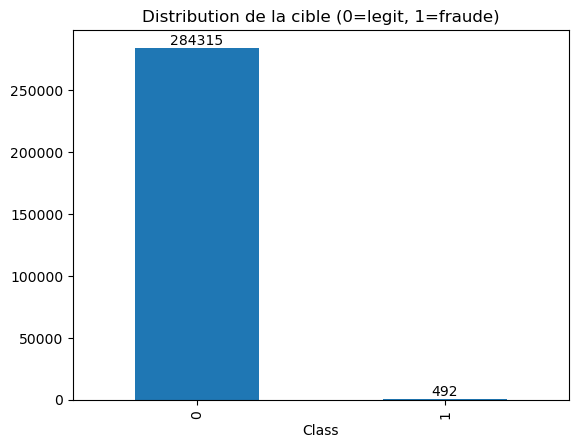

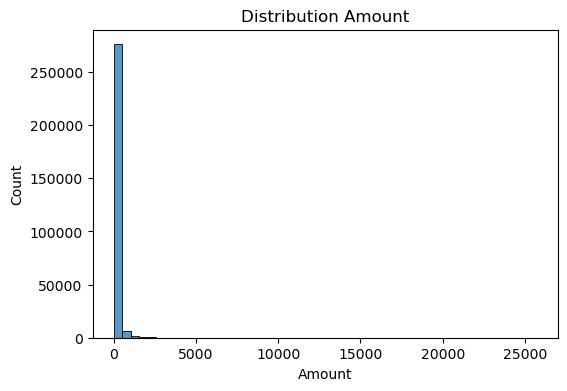

In [4]:
# Répartition de la classe (fort déséquilibre attendu)
ax = df["Class"].value_counts().plot(kind="bar", title="Distribution de la cible (0=legit, 1=fraude)")
ax.bar_label(ax.containers[0], fmt="%.0f"); plt.show()

# Distribution des montants
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=50)
plt.title("Distribution Amount")
plt.show()

## 4-) Split stratifié 80/20 (train/test) et Export CSV

In [5]:
X = df.drop(columns=["Class"])
y = df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# 4.1) Export CSV des splits (train/test) pour traçabilité
train_out = X_train.copy(); train_out["Class"] = y_train
test_out  = X_test.copy();  test_out["Class"]  = y_test
train_out.to_csv("train_split.csv", index=False)
test_out.to_csv("test_split.csv", index=False)
print("→ Splits exportés : train_split.csv & test_split.csv")

Train: (227845, 30) Test: (56962, 30)
→ Splits exportés : train_split.csv & test_split.csv


## 5-) Baseline (données brutes, sans optimisation)

- Choix : StandardScaler + LogisticRegression avec solver="liblinear" (robuste L1/L2) et class_weight="balanced" pour mieux gérer l’énorme déséquilibre
- Fonction coût : la régression logistique minimise la log-loss (entropie croisée) via une descente de gradient (solver liblinear → coordinate descent + méthodes de type Newton)
- Métriques : AP (PR-AUC) et ROC-AUC + seuil F2 (récall > précision) vu la criticité des fraudes manquées

In [6]:
baseline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000, solver="liblinear", class_weight="balanced", random_state=RANDOM_STATE
    )),
])
baseline.fit(X_train, y_train)

# Prédictions train (baseline "sur données brutes")
proba_train_base = baseline.predict_proba(X_train)[:, 1]
logloss_train = log_loss(y_train, proba_train_base)
ap_train = average_precision_score(y_train, proba_train_base)
roc_train = roc_auc_score(y_train, proba_train_base)

print(f"[Baseline-Train] LogLoss={logloss_train:.5f} | AP={ap_train:.5f} | ROC-AUC={roc_train:.5f}")

[Baseline-Train] LogLoss=0.10709 | AP=0.75157 | ROC-AUC=0.98943


## 6-) Seuil optimal Fβ sécurisé (β=2)

Nota : precision_recall_curve renvoie prec, rec, thr avec len(thr) = len(prec) - 1. On aligne sur prec[1:], rec[1:]

In [7]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

def best_threshold_fbeta(y_true, proba, beta=2.0):
    """
    Calcule le seuil qui maximise Fβ sur la courbe PR.
    Retourne: (seuil_opt, fbeta_max, (precision_opt, recall_opt), cm@seuil)
    """
    prec, rec, thr = precision_recall_curve(y_true, proba)
    fbeta = (1 + beta**2) * (prec[1:] * rec[1:]) / (beta**2 * prec[1:] + rec[1:] + 1e-12)
    i = int(np.nanargmax(fbeta))
    thr_opt = float(thr[i])
    pred = (proba >= thr_opt).astype(int)
    cm = confusion_matrix(y_true, pred)
    return thr_opt, float(fbeta[i]), (float(prec[i+1]), float(rec[i+1])), cm

# Évaluation baseline sur train avec F2
thr_b_tr, f2_b_tr, (p_b_tr, r_b_tr), cm_b_tr = best_threshold_fbeta(y_train, proba_train_base, beta=2.0)
print(f"[Baseline-Train] thr*={thr_b_tr:.4f} | F2={f2_b_tr:.4f} | P/R=({p_b_tr:.4f}/{r_b_tr:.4f})")
print("CM@thr (train):")
print(cm_b_tr)

[Baseline-Train] thr*=0.9999 | F2=0.7932 | P/R=(0.7884/0.7944)
CM@thr (train):
[[227366     85]
 [    81    313]]


## 7-) Modèle optimisé : SMOTE et GridSearchCV avec la Pipeline d'imblearn

Nota :
- On enrichit exclusivement le train via SMOTE dans la Pipeline puis GridSearch (C, penalty) sur la LogisticRegression
- Scoring : average_precision (PR-AUC), plus informatif que ROC-AUC pour classes rares

In [9]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),  # appliqué uniquement sur les folds d'entraînement
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="liblinear",          # robuste L1/L2
        class_weight="balanced",     # gère le déséquilibre
        random_state=RANDOM_STATE
    )),
])

param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.1, 1, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC, plus pertinent pour classes rares
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
print("Meilleurs hyperparamètres :", grid.best_params_)
print(f"AP cv moyen : {grid.best_score_:.5f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs hyperparamètres : {'clf__C': 10, 'clf__penalty': 'l2'}
AP cv moyen : 0.75286


## 8-) Fonction commune d’évaluation (test) et comparatif

In [10]:
# Stockage pour rapport final
results = {}
pr_curves = []  # (label, prec[], rec[], ap, (rec_opt, prec_opt))
roc_curves = [] # (label, fpr[], tpr[], roc_auc)

def evaluate_model(label, estimator, X_ts, y_ts, beta=2.0):
    proba = estimator.predict_proba(X_ts)[:, 1]
    ap  = average_precision_score(y_ts, proba)
    roc = roc_auc_score(y_ts, proba)
    thr, f2, (p_op, r_op), cm = best_threshold_fbeta(y_ts, proba, beta=beta)

    # tables et courbes
    prec, rec, _ = precision_recall_curve(y_ts, proba)
    pr_curves.append((label, prec, rec, ap, (r_op, p_op)))
    fpr, tpr, _ = roc_curve(y_ts, proba)
    roc_curves.append((label, fpr, tpr, roc))

    results[label] = {
        "pr_auc": float(ap),
        "roc_auc": float(roc),
        "threshold": float(thr),
        "f2": float(f2),
        "precision@thr": float(p_op),
        "recall@thr": float(r_op),
        "confusion_matrix@thr": cm.tolist(),
    }
    return results[label]

### 8.1) Baseline (test)

In [11]:
res_base = evaluate_model("Baseline LR", baseline, X_test, y_test, beta=2.0)
res_base

{'pr_auc': 0.7189345491364825,
 'roc_auc': 0.9720926514246666,
 'threshold': 0.9999782217074442,
 'f2': 0.8249496981889265,
 'precision@thr': 0.780952380952381,
 'recall@thr': 0.8367346938775511,
 'confusion_matrix@thr': [[56840, 24], [16, 82]]}

### 8.2) LR optimisée (test)

In [12]:
res_lr = evaluate_model("LR + SMOTE (grid)", best_lr, X_test, y_test, beta=2.0)
res_lr

{'pr_auc': 0.724349270367579,
 'roc_auc': 0.9709665309567834,
 'threshold': 0.999994712878301,
 'f2': 0.8266129032255993,
 'precision@thr': 0.7884615384615384,
 'recall@thr': 0.8367346938775511,
 'confusion_matrix@thr': [[56841, 23], [16, 82]]}

### 8.3) RandomForest (test)

In [13]:
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1
).fit(X_train, y_train)
res_rf = evaluate_model("RandomForest", rf, X_test, y_test, beta=2.0)
res_rf

{'pr_auc': 0.8622748060998633,
 'roc_auc': 0.9514541677672756,
 'threshold': 0.16333333333333333,
 'f2': 0.8686868686866627,
 'precision@thr': 0.8349514563106796,
 'recall@thr': 0.8775510204081632,
 'confusion_matrix@thr': [[56846, 18], [12, 86]]}

### 8.4) XGBoost (test)

In [15]:
from xgboost import XGBClassifier  # <- classe correcte

# pondération utile pour le fort déséquilibre (optionnel mais recommandé)
pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",          # AP/PR-AUC en métrique d'entraînement
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scale_pos_weight=pos_weight   # aide sur classes rares
)

xgb_clf.fit(X_train, y_train)
res_xgb = evaluate_model("XGBoost", xgb_clf, X_test, y_test, beta=2.0)
res_xgb

{'pr_auc': 0.870119964776624,
 'roc_auc': 0.9808852916518324,
 'threshold': 0.849485456943512,
 'f2': 0.8402489626554119,
 'precision@thr': 0.9,
 'recall@thr': 0.826530612244898,
 'confusion_matrix@thr': [[56854, 10], [17, 81]]}

### 8.5) Tableau comparatif (trié par AP)

In [16]:
cmp = (pd.DataFrame(results).T
         .loc[:, ["pr_auc", "roc_auc", "f2", "threshold", "precision@thr", "recall@thr"]]
         .sort_values(by="pr_auc", ascending=False))
cmp

,pr_auc,roc_auc,f2,threshold,precision@thr,recall@thr
XGBoost,0.87012,0.980885,0.840249,0.849485,0.9,0.826531
RandomForest,0.862275,0.951454,0.868687,0.163333,0.834951,0.877551
LR + SMOTE (grid),0.724349,0.970967,0.826613,0.999995,0.788462,0.836735
Baseline LR,0.718935,0.972093,0.82495,0.999978,0.780952,0.836735


## 9-) Sélection du meilleur modèle (par AP)

In [17]:
best_label = cmp.index[0]
print("Meilleur modèle (AP):", best_label)
best_label

Meilleur modèle (AP): XGBoost


'XGBoost'

## 10-) Représentations graphiques (PR et ROC)

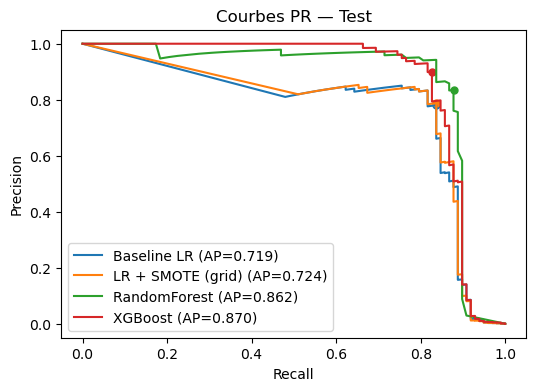

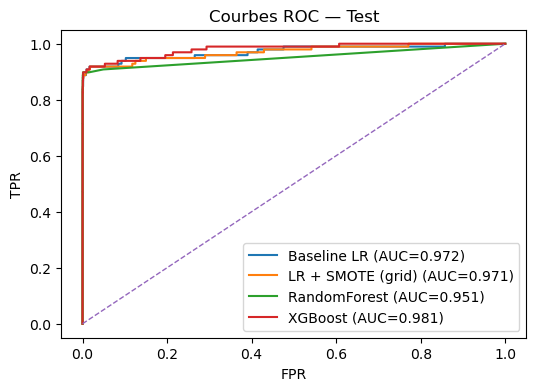

In [22]:
# Purge optionnelle des anciennes figures
for f in glob.glob("reports/figures/*.png"):
    try: os.remove(f)
    except FileNotFoundError: pass

# 10.1) PR curves
fig_pr, ax_pr = plt.subplots(figsize=(6,4))
for label, prec, rec, ap, point in pr_curves:
    ax_pr.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
    if point:
        r_opt, p_opt = point
        ax_pr.scatter([r_opt], [p_opt], s=25)
ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.set_title("Courbes PR — Test"); ax_pr.legend(loc="best")
fig_pr.savefig("reports/figures/pr_curves_test.png", dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig_pr)

# 10.2) ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(6,4))
for label, fpr, tpr, roc in roc_curves:
    ax_roc.plot(fpr, tpr, label=f"{label} (AUC={roc:.3f})")
ax_roc.plot([0,1],[0,1], "--", lw=1)
ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
ax_roc.set_title("Courbes ROC — Test"); ax_roc.legend(loc="best")
fig_roc.savefig("reports/figures/roc_curves_test.png", dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig_roc)

## 11-) Confusion matrix du modèle sélectionné (test @ seuil F2 optimal)

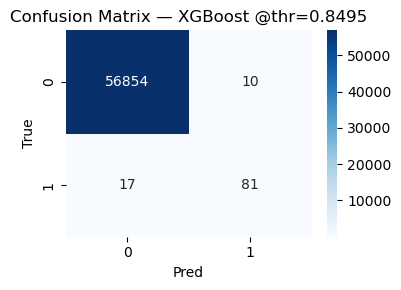

In [23]:
def confusion_from_results(label, X_ts, y_ts):
    thr = results[label]["threshold"]
    proba = None
    if label == "Baseline LR":
        proba = baseline.predict_proba(X_ts)[:, 1]
    elif label == "LR + SMOTE (grid)":
        proba = best_lr.predict_proba(X_ts)[:, 1]
    elif label == "RandomForest":
        proba = rf.predict_proba(X_ts)[:, 1]
    elif label == "XGBoost":
        proba = xgb_clf.predict_proba(X_ts)[:, 1]
    pred = (proba >= thr).astype(int)
    return confusion_matrix(y_ts, pred)

cm_best = confusion_from_results(best_label, X_test, y_test)
plt.figure(figsize=(4,3))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_label} @thr={results[best_label]['threshold']:.4f}")
plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("reports/figures/confusion_matrix_best.png", dpi=200, bbox_inches="tight")
plt.show()

## 12-) Importance des features (LR / RF / XGB)

Nota :
- LR : on utilise les coefficients (après standardisation) -> on trace les valeurs absolues
- RF/XGB : on utilise feature_importances_. On affiche Top-15.

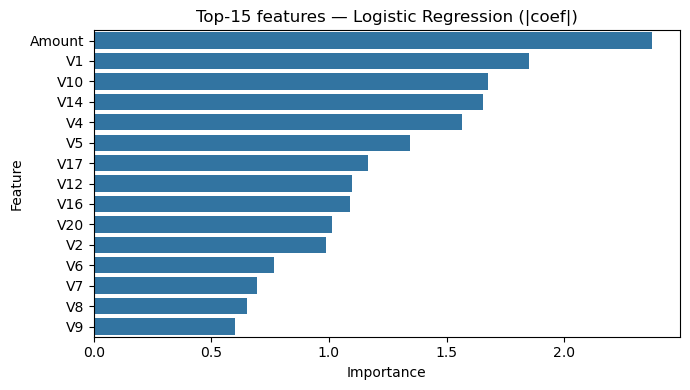

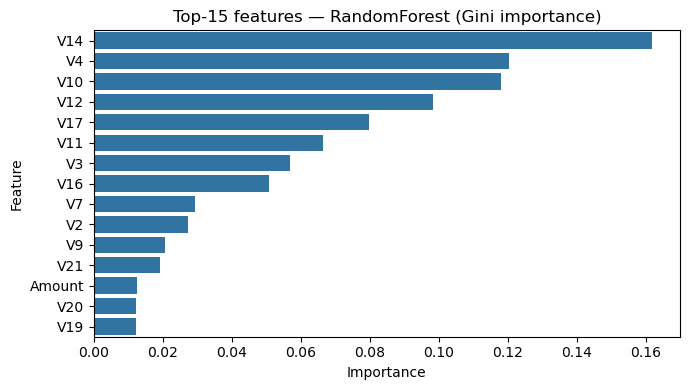

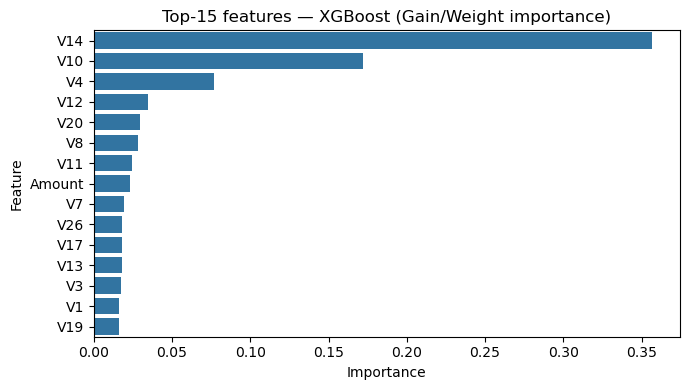

In [24]:
def plot_top_importance(names, scores, title, outpath, top=15):
    idx = np.argsort(scores)[::-1][:top]
    plt.figure(figsize=(7,4))
    sns.barplot(x=scores[idx], y=np.array(names)[idx], orient="h")
    plt.title(title); plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout(); plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.show()

feat_names = X_train.columns.tolist()

# 12.1) Logistic Regression (pipeline best_lr)
# récupération des coefficients du step 'clf' ; StandardScaler normalise l'échelle
lr_coef = np.abs(best_lr.named_steps["clf"].coef_.ravel())
plot_top_importance(
    names=feat_names, scores=lr_coef,
    title="Top-15 features — Logistic Regression (|coef|)",
    outpath="reports/figures/feat_importance_lr.png"
)

# 12.2) RandomForest
rf_imp = rf.feature_importances_
plot_top_importance(
    names=feat_names, scores=rf_imp,
    title="Top-15 features — RandomForest (Gini importance)",
    outpath="reports/figures/feat_importance_rf.png"
)

# 12.3) XGBoost
xgb_imp = xgb_clf.feature_importances_
plot_top_importance(
    names=feat_names, scores=xgb_imp,
    title="Top-15 features — XGBoost (Gain/Weight importance)",
    outpath="reports/figures/feat_importance_xgb.png"
)

## 13-) Rapport et artefacts (métriques JSON + figures)

In [27]:
# JSON des métriques comparatives
with open("reports/metrics.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)
print("✔ Métriques écrites dans reports/metrics.json")
print("✔ Figures écrites dans reports/figures/")

✔ Métriques écrites dans reports/metrics.json
✔ Figures écrites dans reports/figures/
